In [17]:
#!/usr/bin/env python3

from __future__ import print_function, division
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'
import seaborn #plotting lib, but just adding makes the matplotlob plots better
import glob # use this for file IO later

import math

from numpy import sin, cos, pi, sqrt, dot
import scipy as sp
from scipy import stats, optimize
from scipy import linalg as la
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import pdb

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata, interp1d
from scipy import signal
from scipy.optimize import curve_fit
from scipy import interpolate

from scipy.interpolate import griddata, interp1d

import sys
sys.path.append("..")
                
from pprz_data.pprz_data import DATA
import matplotlib as mpl

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Reading the flight log : 
Messages are recorded at different frequency, therefore need to be interpolated in order to generate an easy to work with dataframe. (Some messages will not be found, thats normal ! as the loading function is a generic one to handle different types of flight logs...)

In [4]:
ac_id = '7'
filename = '../data/20_11_2020_Laurac/flight3/20_11_20__11_28_20_SD.data'
pprz = DATA(filename, ac_id, data_type='flight')
pprz_df = pprz.df_All

 Generating 3D velocity...
 Fault Telemetry msg doesnt exist 
 Actuators msg doesnt exist 
 Gust msg does not exist 
 Rotorcraft_fp msg does not exist 
Min time : 34.402 Maximum time : 1433.522


In [6]:
# You can check the columns :
pprz_df.columns

Index(['phi', 'psi', 'theta', 'mode', 'Ax', 'Ay', 'Az', 'east', 'north',
       'course', 'alt', 'vel', 'climb', 'vel_3d', 'Gx', 'Gy', 'Gz', 'C0', 'C1',
       'C2', 'Throttle', 'Volt', 'Amp', 'Watt', 'mAh', 'Wh', 'Ps', 'Pdyn_AD',
       'temp', 'qnh', 'amsl_baro', 'airspeed', 'TAS', 'D_roll', 'D_pitch',
       'D_course', 'D_x', 'D_y', 'D_altitude', 'D_climb', 'D_airspeed',
       'sp_Va', 'sp_aoa', 'sp_beta', 'sp_dyn_p', 'sp_sta_p', 'sp_wx', 'sp_wz',
       'sp_d_wx', 'sp_d_wz', 'sp_w_power'],
      dtype='object')

In [7]:
# I made an error on the onboard calculations, and as I dont want to loose this data I am correcting it after the flights !
# This has to be corrected on every flight from  20/11/2020 !!! 
pprz_df['wx_correct'] = pprz_df.sp_wx
pprz_df['wz_correct'] = -pprz_df.sp_wz - 2.*pprz_df.climb 

### You can check a portion of the flight (for altitude):
Initial part is the take-off, then there is an unstructured part showing the flight before stating of the inclined circle...
Then the last portion is mainly the altitude difference coming from the inclination of teh trajectory.

<AxesSubplot:xlabel='time'>

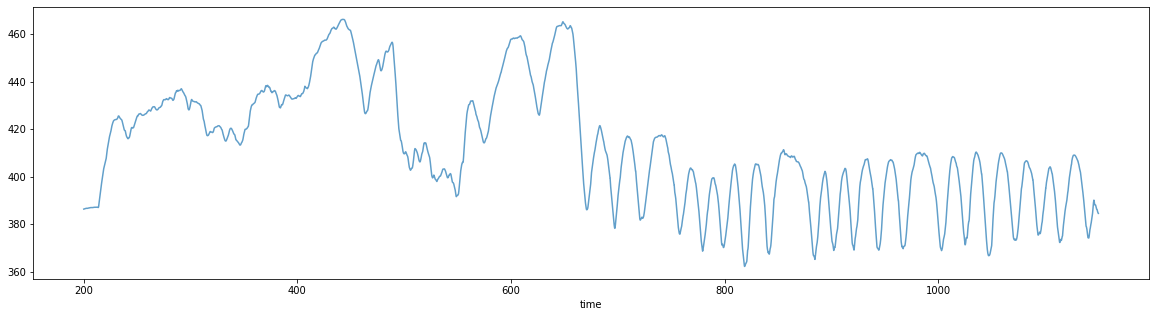

In [8]:
pprz_df[200:1150].alt.plot(figsize=(20,5), alpha=0.7)

In [9]:
def Process_2(df, start, finish, dict_nr=None, filename=None, filter_order=2, cut_off_freq=1):
    sf = 100
    st=start;fn=finish;
    xlim1=start;xlim2=finish;
    b, a = signal.butter(filter_order, cut_off_freq/(sf/2), 'low', analog=False)
    padlen = 100
    CD_0 = 0.028
    rho = 1.225
    S_ref= 0.21
    mass  = 1.05   # Aircraft mass [kg]
    AR = 11.84
    e = 0.85
    gee   = 9.81
    alt_0 = df.alt[st:st+1/sf].values #383. # Reference zero potential energy altitude ASL[m]
    
    ########################
    time = df[st:fn].index
#     vel   = signal.filtfilt(b, a, df.airspeed[st:fn].values, padlen=padlen) # method="gust")
    vel   = signal.filtfilt(b, a, df.sp_Va[st:fn].values, padlen=padlen)
    climb = signal.filtfilt(b, a, df.climb[st:fn].values, padlen=padlen)
    alpha = signal.filtfilt(b, a,df.sp_aoa[st:fn].values, padlen=padlen)
    pitch = signal.filtfilt(b, a,df.theta[st:fn].values, padlen=padlen)
    roll  = signal.filtfilt(b, a,df.phi[st:fn].values, padlen=padlen)
    yaw   = signal.filtfilt(b, a,df.psi[st:fn].values, padlen=padlen)
    p     = signal.filtfilt(b, a,df.Gx[st:fn].values, padlen=padlen)
    q     = signal.filtfilt(b, a,df.Gy[st:fn].values, padlen=padlen)
    Ax    = signal.filtfilt(b, a,df.Ax[st:fn].values, padlen=padlen)
    Ay    = signal.filtfilt(b, a,df.Ay[st:fn].values, padlen=padlen)
    Az    = signal.filtfilt(b, a,df.Az[st:fn].values, padlen=padlen)
    alt   = signal.filtfilt(b, a,df.alt[st:fn].values, padlen=padlen)
    throttle = signal.filtfilt(b, a,df.Throttle[st:fn].values, padlen=padlen)
    electrical_power = signal.filtfilt(b, a,df.Watt[st:fn].values, padlen=padlen)
    groundspeed = signal.filtfilt(b, a,df.vel[st:fn].values, padlen=padlen)
    groundspeed_3d = signal.filtfilt(b, a,df.vel_3d[st:fn].values, padlen=padlen)
    
    # CHECK THE SOURCE of WX and WZ (Can come from sp, or calculated, etc...)
    wx = signal.filtfilt(b, a, df.wx_correct[st:fn].values, padlen=padlen)
    wz = signal.filtfilt(b, a, df.wz_correct[st:fn].values, padlen=padlen)
    ########################
    
#     window=300
#     st = st-window/sf
#     time = df[st:fn].index[window:]
# #     vel   = df.airspeed[st:fn].rolling(window=window).mean().values[window:]
#     vel   = df.sp_Va[st:fn].rolling(window=window).mean().values[window:]
#     climb = df.climb[st:fn].rolling(window=window).mean().values[window:]
#     alpha = df.sp_aoa[st:fn].rolling(window=window).mean().values[window:]
#     pitch = df.theta[st:fn].rolling(window=window).mean().values[window:]
#     roll  = df.phi[st:fn].rolling(window=window).mean().values[window:]
#     yaw   = df.psi[st:fn].rolling(window=window).mean().values[window:]
#     p     = df.Gx[st:fn].rolling(window=window).mean().values[window:]
#     q     = df.Gy[st:fn].rolling(window=window).mean().values[window:]
#     Ax    = df.Ax[st:fn].rolling(window=window).mean().values[window:]
#     Ay    = df.Ay[st:fn].rolling(window=window).mean().values[window:]
#     Az    = df.Az[st:fn].rolling(window=window).mean().values[window:]
#     alt   = df.alt[st:fn].rolling(window=window).mean().values[window:]
#     throttle         = df.Throttle[st:fn].rolling(window=window).mean().values[window:]
#     electrical_power = df.Watt[st:fn].rolling(window=window).mean().values[window:]
#     groundspeed      = df.vel[st:fn].rolling(window=window).mean().values[window:]
#     groundspeed_3d   = df.vel_3d[st:fn].rolling(window=window).mean().values[window:]
    
#     # CHECK THE SOURCE of WX and WZ (Can come from sp, or calculated, etc...)
#     wx = df.wx_correct[st:fn].rolling(window=window).mean().values[window:]
#     wz = df.wz_correct[st:fn].rolling(window=window).mean().values[window:]
    ########################
    
    
    Lift = -Az * mass
    CL = Lift/ (0.5*rho*vel*vel*S_ref)
    CD = CD_0 + CL*CL/(np.pi*AR*e)
    gamma = pitch - alpha

    
    d_wx = np.hstack((np.zeros(1), np.diff(wx,1,axis=0)))*sf
    d_wz = np.hstack((np.zeros(1), np.diff(wz,1,axis=0)))*sf
    d_alt = np.hstack((np.zeros(1), np.diff(alt,1,axis=0)))*sf
    # this is like F=ma , where acceleration is coming from the change of w_x
#     F_fi = mass*d_wx*cos(gamma)*d_alt
    D = -0.5*rho*vel**2*S_ref*CD
    ax_wind = -d_wx*(sin(gamma) * cos(gamma) )
    az_wind =  d_wz*cos(gamma)

    P_drag= vel * D
    P_dwx = -d_wx*(-vel * np.sign(gamma) * cos(gamma) ) # With sign only
    P_dwz =  d_wz*(vel * sin(gamma) )

    e_pot = (mass*gee*(alt-alt_0))
#     e_kin = (0.5*mass*groundspeed_3d**2)/(mass*gee)
#     e_tot = e_pot + e_kin


    e_kin_air = (0.5*mass*vel**2)
    e_tot_air = e_kin_air + e_pot

    
#     mpl.style.use('default') #seaborn, default, seaborn-paper
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams["font.family"] = "Serif"
    plt.rcParams["font.size"] = 11  

    fig = plt.figure(figsize=(10,14.5))
    ax = fig.add_subplot(611)
    ax.set_title('Energy in Air-Path Frame')
    ax.plot(time,e_tot_air, label='$E_{Total}$')
    ax.plot(time,e_kin_air, label='$E_{Kinetic}$')
    ax.plot(time,e_pot, label='$E_{Potential}$')
    # plt.plot(cycle_time,e_pot, label='Potential Energy');plt.plot(cycle_time,e_tot_air, label='Total Energy in A');
    ax.grid();ax.legend();ax.set_ylabel('Energy [J]')#plt.ylabel('Energy/(mg) [m]')
    ax.set_xlim([xlim1,xlim2]);#;plt.xlim([0,1])#;plt.ylim([0,70])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(612)
    ax.plot(time,(alt-alt_0), label='Height AGL')
    ax.plot(time,vel, label='$V_a$');
#     plt.plot(time, groundspeed, label='$V_{i-XY}$');
    ax.plot(time, groundspeed_3d, label='$V_{i}$');
    ax.grid();
    ax.set_ylabel('Height AGL [m] $\&$ \\\ Speed [m/s]');
    ax.legend();
    ax.set_xlim([xlim1,xlim2]); #plt.ylim([0,35]) #plt.xlim([0,1]);
    ax.set_xticklabels([])
#     plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='on', labeltop='off', labelright='off', labelbottom='off')

    ax = fig.add_subplot(613)
#     plt.plot(t_pprz,CL, label='$C_L$');
    ax.plot(time,gamma*57.3, label='$\gamma$ [deg]');
    ax.plot(time,wx, label='$W_x$');
    ax.plot(time,d_wx, label='$\dot{W_x}$');
#     plt.plot(t_pprz,d_wx_alt, label='$\dot{W_xalt}$');
    ax.plot(time,wz, label='$W_z$');
    ax.plot(time,-climb, label='$Vi_z$');
#     plt.plot(time,vel_pprz*cos(np.deg2rad(gamma_pprz)), label='V cos gama');
#     plt.plot(time,vel_pprz*sin(np.deg2rad(gamma_pprz)), label='V sin gama');
#     plt.plot(time,vel_pprz**2*cos(np.deg2rad(gamma_pprz))*sin(np.deg2rad(gamma_pprz)), label='V^2 sin gama cos gama');
    ax.grid();ax.legend();ax.set_ylabel('  Flight Path ($\gamma$) [deg] \\\  Wind Speed [$m/s$] \\\  Gradient [$m/s^2$]');#plt.ylim([-12,12]);
    ax.set_xlim([xlim1,xlim2]);ax.set_xticklabels([])

    ax = fig.add_subplot(614)
    ax.plot(time, P_drag, color='red', label='$P_D$  [W], $\sum{P_D}$ = %0.2f [Ws]' % (np.nansum(P_drag)/100) ) 
#     plt.annotate('$\sum{P_D}$ = %0.2f [Ws]' % (np.nansum(P_drag)/100),
#             xy=(.6, .385), xycoords='figure fraction',
#             horizontalalignment='left', verticalalignment='top',
#             fontsize=12, bbox=dict(boxstyle="round", fc=".97"))
    #; plt.annotate('$\sum{P_D}$ = %0.2f [Ws]' % (np.nansum(P_drag)/100),(200,-200))
#     plt.fill_between(t_pprz,0,P_drag, alpha=0.50, color='red', interpolate=True,label='DRAG Power, sum = %0.2f Ws' % (np.nansum(P_drag)/100))
    ax.plot(time,P_dwx, color='black', alpha=0.6, label='$P_{\dot{W}_X}$ [W], $\sum{P_{\dot{W}_X}}$ = %0.2f [Ws]' % (np.nansum(P_dwx)/100) );
    ax.fill_between(time,0,P_dwx, where=(P_dwx >= 0), alpha=0.50, color='green', interpolate=True)#, label='P$_{\dot{w_x}}$, sum = %0.2f [Ws]' % (np.nansum(P_dwx)/100))#, label='P$_{\dot{w}}$');
    ax.fill_between(time,0,P_dwx, where=(P_dwx < 0), alpha=0.50, color='red', interpolate=True)#, label='P$_{\dot{w}}$');
    ax.grid();ax.legend();ax.set_ylabel('Power ($P_{\dot{W}_X}\, \& \, P_D$)  [W]');ax.set_xlim([xlim1,xlim2]);plt.ylim([-100,120])#;plt.xlim([0,1])#;
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(615)
    ax.plot(time,P_dwz, color='black', alpha=0.3, label='$P_{\dot{W_Z}}$, $\sum{P_{\dot{W_Z}}}$ = %0.2f [Ws]' % (np.nansum(P_dwz)/100) );
    ax.fill_between(time,0,P_dwz, where=(P_dwz >= 0), alpha=0.50, color='green', interpolate=True)#, label='P$_{\dot{w}}$');
    ax.fill_between(time,0,P_dwz, where=(P_dwz < 0), alpha=0.50, color='red', interpolate=True)#, label='P$_{\dot{w}}$');
    ax.grid();plt.legend();plt.ylabel('Power ($P_{\dot{W}_Z}$)  [W]');ax.set_xlim([xlim1,xlim2]);ax.set_ylim([-100,120])#;plt.xlim([0,1])#;plt.ylim([-10,10])
    ax.set_xticklabels([])
    
#     plt.subplot(515)#;plt.plot(t_pprz,(D), label='Drag');
#     # plt.plot(cycle_time,a_wind, label='$F_{fi}$');plt.grid();plt.legend();plt.xlim([0,1])#;plt.ylim([360,460])
#     # plt.plot(cycle_time,additional, label='P$_{\dot{w}}$');
#     plt.plot(t_pprz,additional, color='black', alpha=0.2, label='P$_{\dot{w}}$');
#     plt.fill_between(t_pprz,0,additional, where=(additional >= 0), alpha=0.50, color='green', interpolate=True, label='P$_{\dot{w}}$');
#     plt.fill_between(t_pprz,0,additional, where=(additional < 0), alpha=0.50, color='red', interpolate=True, label='P$_{\dot{w}}$');
#     plt.grid();plt.ylabel('additional...');plt.ylim([-250,200])#; plt.xlim([0,1])
    # plt.legend()
#     plt.xlabel("Cycle Time $(t/t_{cycle})$ [-]")
    throttle_limit = 40.
    propulsion_eff = 0.4
    ax = fig.add_subplot(616);
    ax.plot(time,throttle, label='Throttle,  Averaged = %0.2f' % (np.nanmean(throttle)) );
    ax.fill_between(time,0,electrical_power, where=(throttle >= throttle_limit), alpha=0.20, color='grey', interpolate=True, label='$\sim\sum{P_{Aero.}}$ = %0.2f [Ws]' % (np.nansum(electrical_power[throttle>=throttle_limit])/100.* propulsion_eff))
    ax.plot(time,electrical_power, label='$P_{Elec.}$ [W] , $\sum{P_{Elec.}}$ = %0.2f [Ws]' % (np.nansum(electrical_power)/100) ); #np.nanmean(electrical_power),
    ax.grid();plt.legend();ax.set_ylabel('Throttle [\%] \& \\\ Elec. Power ($P_{Elec.}$) [W]');ax.set_xlim([xlim1,xlim2]);#;plt.xlim([xlim1,xlim2]);plt.ylim([0,100])
#     plt.xlabel("Time [s]")
    ax.set_xlabel('Time [s]')
    if filename !=None: plt.savefig('plots/'+ filename, dpi=30, bbox_inches='tight')
    if dict_nr != None:
        circles.dict[dict_nr]['Power_balance'] = e_tot[-1] - next(x for x in e_tot if not math.isnan(x))
        circles.dict[dict_nr]['Power_wx'] = np.nansum(P_dwx)/100
        circles.dict[dict_nr]['Power_wz'] = np.nansum(P_dwz)/100
        circles.dict[dict_nr]['Power_drag'] = np.nansum(P_drag)/100
        circles.dict[dict_nr]['Throttle']   = np.nanmean(throttle)
    plt.show()
    
    plt.plot(wx,alt)
    plt.show()
    
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams["font.family"] = "Serif"#"Times New Roman" #"Serif"#     plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 11
    fig = plt.figure(figsize=(10,4))
    plt.subplot(211)
#     plt.plot(time,df.airspeed[st:fn].values[window:],alpha=0.4, color='black', label='Raw Signal')
#     plt.plot(time,df.sp_Va[st:fn].values[window:],alpha=0.4, color='black', label='Raw Signal')
    plt.plot(time,df.sp_Va[st:fn].values,alpha=0.4, color='black', label='Raw Signal')
    plt.plot(time,vel, label='Filtered Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Airspeed [m/s]')
    plt.grid();plt.legend()
    plt.subplot(212)
#     plt.plot(time,df.sp_aoa[st:fn].values[window:]*57.3, alpha=0.4, color='black', label='Raw Signal')
    plt.plot(time,df.sp_aoa[st:fn].values*57.3, alpha=0.4, color='black', label='Raw Signal')
    plt.plot(time,alpha*57.3, label='Filtered Signal')
    plt.xlabel('Time [s]')
    plt.ylabel(r'Angle of Attack ($\alpha$) [deg]')
#     plt.axvspan(380,1140, alpha=0.3, color='grey')
    plt.grid();plt.legend()
#     plt.savefig('plots/flight_altitude.pdf', dpi=100, bbox_inches='tight')
    plt.savefig('plots/'+ 'noisy_data.pdf', dpi=30, bbox_inches='tight')
    plt.show()

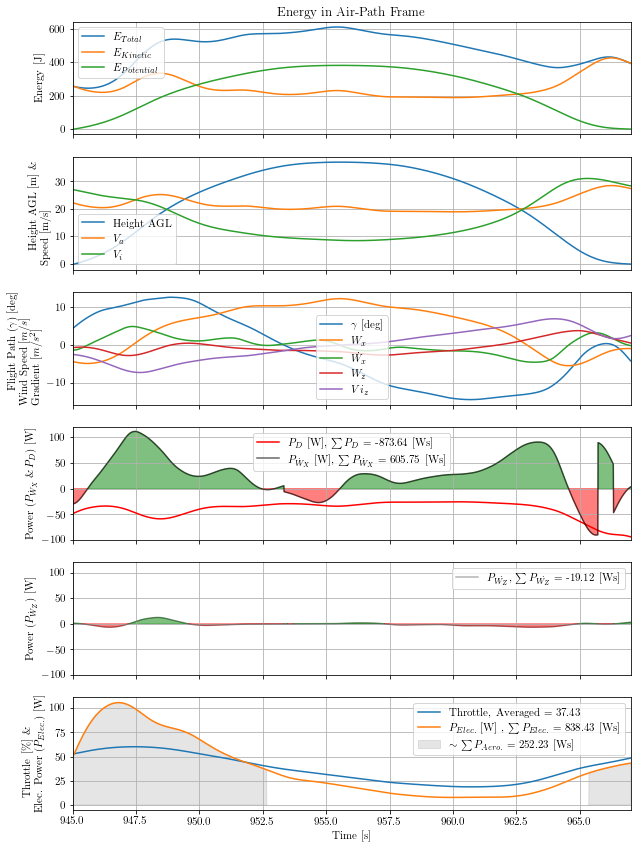

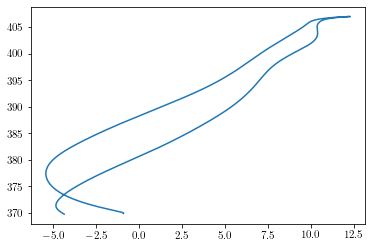

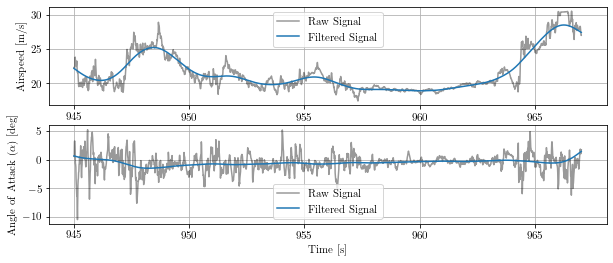

In [10]:
# Process_2(pprz_df,945,969,filter_order=2, cut_off_freq=0.3, filename='20_11_20__11_28_20_945-969_ma_filter.pdf' )
# Process_2(pprz_df,885,922,filter_order=2, cut_off_freq=0.3, filename='20_11_20__11_28_20_885-922_ma_filter.pdf')
# Process_2(pprz_df,800,1140,filter_order=2, cut_off_freq=0.3, filename='20_11_20__11_28_20_800-1140_ma_filter.pdf')

Process_2(pprz_df,945,967,filter_order=2, cut_off_freq=0.3, filename='20_11_20__11_28_20_945-967_bw_filter.pdf' )
# Process_2(pprz_df,885,921,filter_order=2, cut_off_freq=0.3, filename='20_11_20__11_28_20_885-921_bw_filter.pdf')
# Process_2(pprz_df,800,1140,filter_order=2, cut_off_freq=0.3, filename='20_11_20__11_28_20_800-1140_bw_filter.pdf')

#     plt.savefig(filename+'.pdf', dpi=200, bbox_inches='tight')